In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import pickle
from pathlib import Path
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils import setup_logger
from mcmc.utils.plot import plot_decay_curve, plot_distance_weight_matrix, plot_summary_stats

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are errors with LAMMPS
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

Initialize test slab and parameters

In [3]:
# Initialize paths
surface_name = "Si_111_5x5"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)
logging.getLogger(
    "matplotlib.font_manager"
).disabled = True  # disable matplotlib font manager logging

# Load prepared pristine slab
try:
    with open("data/Si_111_5x5/Si_111_5x5_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "LAMMPS",
    "optimizer": "LAMMPS",
    "kim_potential": True,
    "chem_pots": {"Si": 0},  # change to 0 here
    "relax_atoms": True,
    "relax_steps": 100,
    "run_dir": run_folder,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 64,
    "start_temp": 0.1,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "canonical": True,
    "num_ads_atoms": 50,
    "require_distance_decay": True,
    "require_per_atom_energies": True,
    "adsorbates": ["Si"],
    "run_folder": run_folder,
}

Obtain adsorption sites to calculate distance-based weights

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)[system_settings["ads_site_type"]]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 3.849,  2.222, 17.   ]), array([ 5.774,  5.556, 17.   ]), array([ 7.699,  8.89 , 17.   ]), array([ 9.623, 12.223, 17.   ]), array([11.548, 15.557, 17.   ])]...


Calculate distance-based weights

In [5]:
from pymatgen.core.structure import Molecule

distance_decay = True
distance_decay_factor = 2.35
ads_mol = Molecule(["Si"], [[0, 0, 0]])

# save pymatgen sites
for ads_coord in ads_positions:
    all_ads_slab = site_finder.add_adsorbate(
        ads_mol, ads_coord, repeat=None, translate=False, reorient=False
    )
    site_finder.slab = all_ads_slab

# set tags to 1 for surface atoms
tags = np.where(np.array(all_ads_slab.site_properties["surface_atoms"]) == 1.0, 1, 0)
print(tags)
all_ads_slab.add_site_property("tags", tags)

# convert to ase
all_ads_slab_ase = AseAtomsAdaptor.get_atoms(all_ads_slab)
distances = all_ads_slab_ase.get_all_distances(mic=True)
ads_coord_distances = distances[-len(ads_positions) :, -len(ads_positions) :]
print(f"ads coords distances shape {ads_coord_distances.shape}")

# Compute distance decay matrix using softmax
distance_weight_matrix = softmax(-ads_coord_distances / distance_decay_factor, axis=1)

assert np.allclose(np.sum(distance_weight_matrix, axis=1), 1.0)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ads coords distances shape (294, 294)


Show distance weight matrix and the decay plot

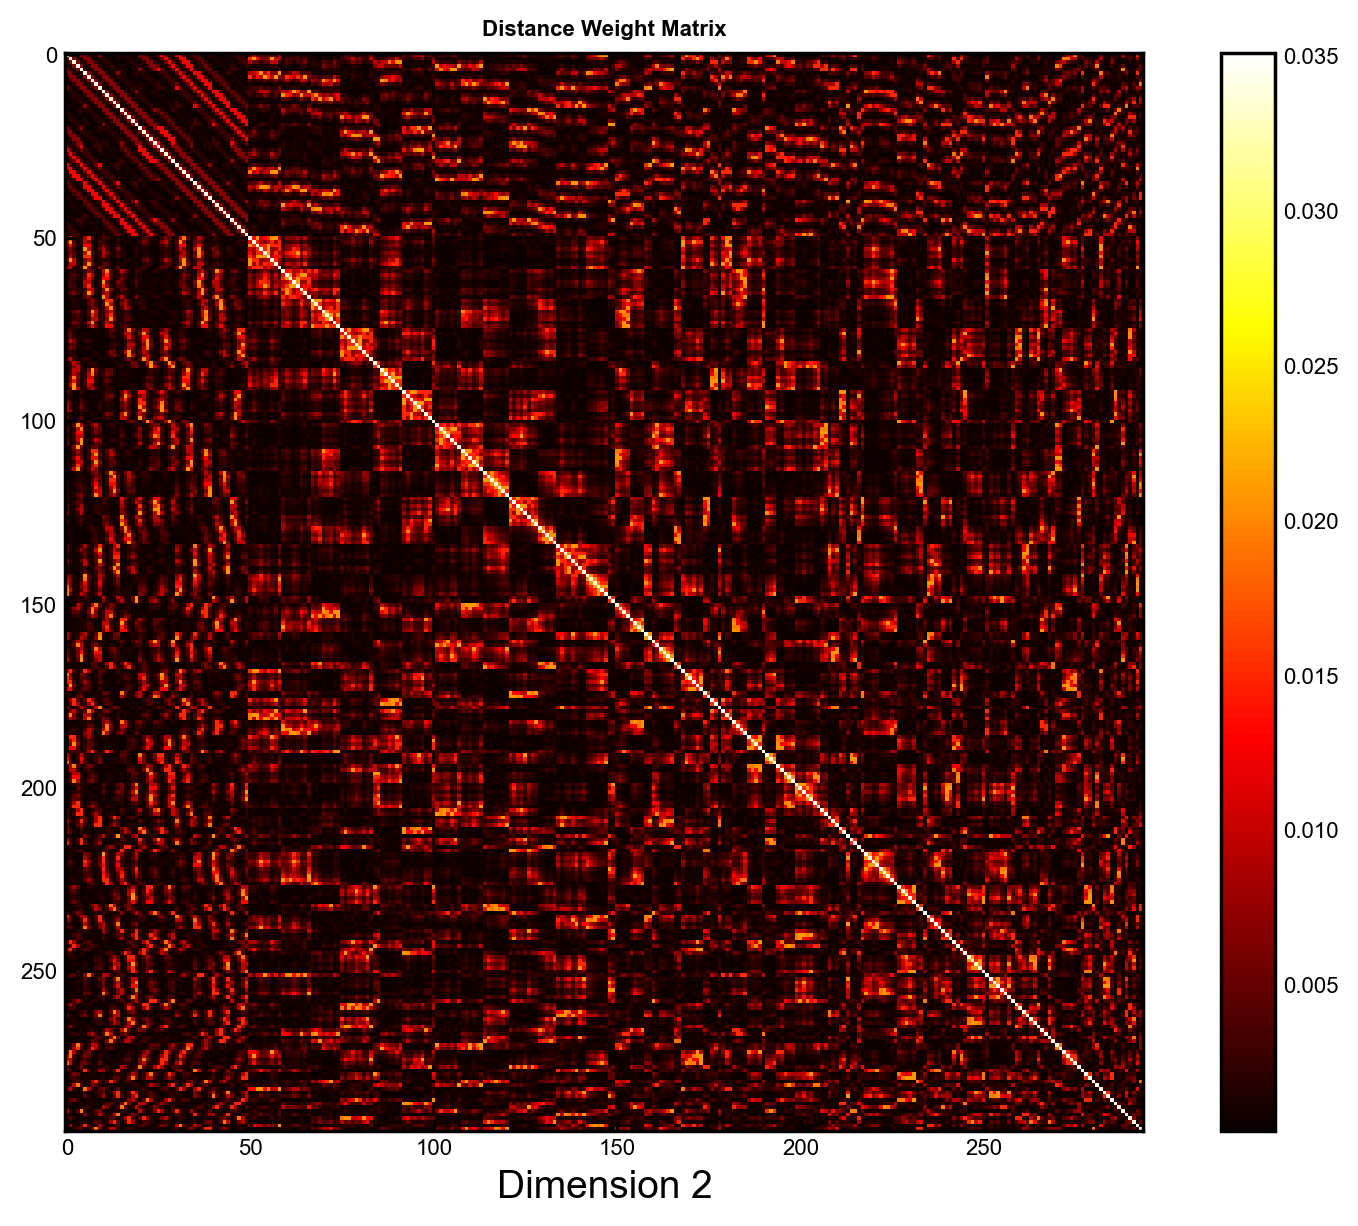

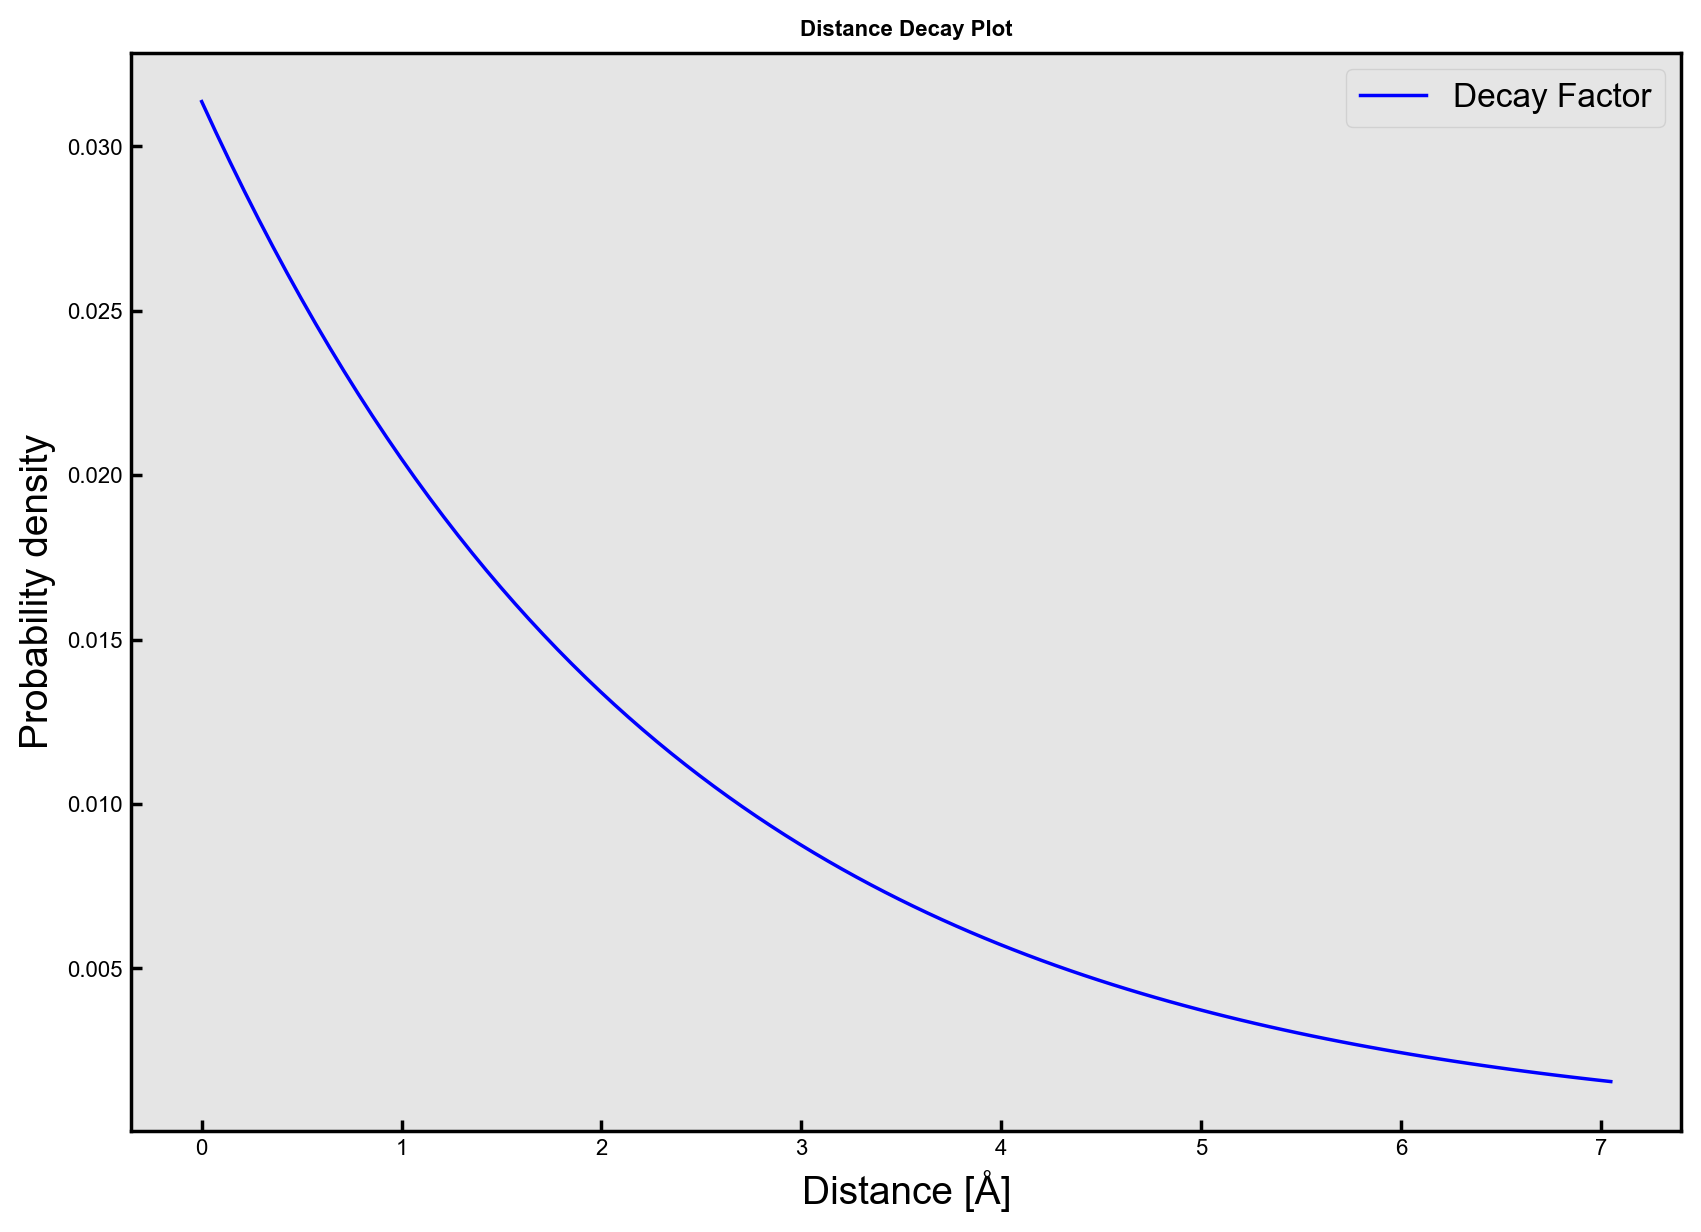

In [6]:
fig = plot_distance_weight_matrix(distance_weight_matrix, save_folder=run_folder)
plt.show()
fig = plot_decay_curve(distance_decay_factor, save_folder=run_folder)
plt.show()

Set up LAMMPS (calculator). Requires a `lammps_config.json` and a `lammps_template.txt` in `run_dir`

In [7]:
from mcmc.calculators import LAMMPSSurfCalc

lammps_surf_calc = LAMMPSSurfCalc()
lammps_surf_calc.set(**calc_settings)

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
/home/dux/miniforge3/envs/vssr-mc/lib/python3.11/site-packages/models


10:43:24 - mcmc.calculators | INFO: run directory: Si_111_5x5 is set from parameters
10:43:24 - mcmc.calculators | INFO: relaxation steps: 100 is set from parameters
10:43:24 - mcmc.calculators | INFO: kim potential: True is set from parameters


{'calc_name': 'LAMMPS',
 'optimizer': 'LAMMPS',
 'kim_potential': True,
 'chem_pots': {'Si': 0},
 'relax_atoms': True,
 'relax_steps': 100,
 'run_dir': PosixPath('Si_111_5x5')}

Initialize surface system

In [8]:
surface = SurfaceSystem(
    pristine_slab,
    ads_coords=ads_positions,
    calc=lammps_surf_calc,
    system_settings=system_settings,
    distance_weight_matrix=distance_weight_matrix,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "Si_111_5x5_all_virtual_ads.cif")

10:43:24 - mcmc.system | INFO: Initializing 294 virtual atoms
10:43:24 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
10:43:24 - mcmc.system | INFO: Number of pristine atoms is 100
10:43:24 - mcmc.system | INFO: Bulk indices are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59

Total wall time: 0:00:00


Test calculate pristine surface

In [9]:
print(f"Energy {surface.get_potential_energy():.3f} eV")

10:43:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Energy -379.107 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `Si(111)_5x5/` folder.

10:43:24 - mcmc.mcmc | INFO: Using run folder Si_111_5x5


10:43:24 - mcmc.mcmc | INFO: Randomly adsorbing sites
10:43:24 - mcmc.events.criterion | ERROR: No surface energy found in results dict
10:43:24 - mcmc.calculators | INFO: None
10:43:24 - mcmc.calculators | INFO: None
10:43:24 - mcmc.calculators | INFO: None
10:43:24 - mcmc.calculators | INFO: None
10:43:24 - mcmc.calculators | INFO: None
10:43:24 - mcmc.calculators | INFO: None
10:43:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00


10:43:25 - mcmc.calculators | INFO: None
10:43:25 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None
10:43:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:26 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00


10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:27 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.mcmc | INFO: There are 100 atoms in pristine slab
10:43:28 - mcmc.mcmc | INFO: Running with total_sweeps = 10, sweep_size = 64, start_temp = 0.100
10:43:28 - mcmc.mcmc | INFO: Starting with iteration 0
10:43:28 - mcmc.mcmc | INFO: Temperature schedule is: ['0.100', '0.100', '0.100', '0.100', '0.100', '0.100', '0.100', '0.100', '0.100', '0.100']
10:43:28 - mcmc.mcmc | INFO: In sweep 1 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None
10:43:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:29 - mcmc.calculators | INFO: None
10:43:29 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:30 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:31 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.calculators | INFO: None
10:43:32 - mcmc.mcmc | INFO: At iter 64


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.system | INFO: Optimized structure has surface energy = -552.218
10:43:33 - mcmc.mcmc | INFO: In sweep 2 out of 10
10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None
10:43:33 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None
10:43:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None
10:43:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:36 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.calculators | INFO: None
10:43:37 - mcmc.mcmc | INFO: At iter 128


Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.system | INFO: Optimized structure has surface energy = -555.804
10:43:38 - mcmc.mcmc | INFO: In sweep 3 out of 10
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:38 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None
10:43:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:40 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:41 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.mcmc | INFO: At iter 192


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.calculators | INFO: None
10:43:42 - mcmc.system | INFO: Optimized structure has surface energy = -555.804
10:43:42 - mcmc.mcmc | INFO: In sweep 4 out of 10
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:43 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:44 - mcmc.calculators | INFO: None
10:43:44 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:45 - mcmc.calculators | INFO: None
10:43:45 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.calculators | INFO: None
10:43:46 - mcmc.mcmc | INFO: At iter 256


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.system | INFO: Optimized structure has surface energy = -557.624
10:43:47 - mcmc.mcmc | INFO: In sweep 5 out of 10
10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.calculators | INFO: None
10:43:47 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:48 - mcmc.calculators | INFO: None
10:43:48 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:49 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:50 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.calculators | INFO: None
10:43:51 - mcmc.mcmc | INFO: At iter 320


Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.system | INFO: Optimized structure has surface energy = -558.231
10:43:52 - mcmc.mcmc | INFO: In sweep 6 out of 10
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None
10:43:52 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:53 - mcmc.calculators | INFO: None
10:43:53 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:54 - mcmc.calculators | INFO: None
10:43:54 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:55 - mcmc.calculators | INFO: None
10:43:56 - mcmc.calculators | INFO: None
10:43:56 - mcmc.calculators | INFO: None
10:43:56 - mcmc.calculators | INFO: None
10:43:56 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:56 - mcmc.calculators | INFO: None
10:43:56 - mcmc.calculators | INFO: None
10:43:56 - mcmc.calculators | INFO: None
10:43:56 - mcmc.calculators | INFO: None
10:43:56 - mcmc.mcmc | INFO: At iter 384


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.system | INFO: Optimized structure has surface energy = -562.844
10:43:57 - mcmc.mcmc | INFO: In sweep 7 out of 10
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:57 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None
10:43:58 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None
10:43:59 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:43:59 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:00 - mcmc.calculators | INFO: None
10:44:00 - mcmc.calculators | INFO: None
10:44:01 - mcmc.calculators | INFO: None
10:44:01 - mcmc.calculators | INFO: None
10:44:01 - mcmc.mcmc | INFO: At iter 448


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:01 - mcmc.calculators | INFO: None
10:44:01 - mcmc.calculators | INFO: None
10:44:01 - mcmc.calculators | INFO: None
10:44:01 - mcmc.system | INFO: Optimized structure has surface energy = -565.366
10:44:01 - mcmc.mcmc | INFO: In sweep 8 out of 10
10:44:01 - mcmc.calculators | INFO: None
10:44:01 - mcmc.calculators | INFO: None
10:44:01 - mcmc.calculators | INFO: None
10:44:01 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:01 - mcmc.calculators | INFO: None
10:44:01 - mcmc.calculators | INFO: None
10:44:01 - mcmc.calculators | INFO: None
10:44:01 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None
10:44:02 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:03 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:04 - mcmc.calculators | INFO: None
10:44:04 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.calculators | INFO: None
10:44:05 - mcmc.mcmc | INFO: At iter 512


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.system | INFO: Optimized structure has surface energy = -565.366
10:44:06 - mcmc.mcmc | INFO: In sweep 9 out of 10
10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.calculators | INFO: None
10:44:06 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:07 - mcmc.calculators | INFO: None
10:44:07 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None
10:44:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None
10:44:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:10 - mcmc.calculators | INFO: None
10:44:10 - mcmc.calculators | INFO: None
10:44:10 - mcmc.calculators | INFO: None
10:44:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:10 - mcmc.calculators | INFO: None
10:44:10 - mcmc.calculators | INFO: None
10:44:10 - mcmc.calculators | INFO: None
10:44:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:10 - mcmc.calculators | INFO: None
10:44:10 - mcmc.calculators | INFO: None
10:44:10 - mcmc.calculators | INFO: None
10:44:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:10 - mcmc.calculators | INFO: None
10:44:10 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.calculators | INFO: None
10:44:11 - mcmc.mcmc | INFO: At iter 576


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:12 - mcmc.calculators | INFO: None
10:44:12 - mcmc.calculators | INFO: None
10:44:12 - mcmc.calculators | INFO: None
10:44:12 - mcmc.system | INFO: Optimized structure has surface energy = -565.366


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:13 - mcmc.mcmc | INFO: In sweep 10 out of 10
10:44:13 - mcmc.calculators | INFO: None
10:44:13 - mcmc.calculators | INFO: None
10:44:13 - mcmc.calculators | INFO: None
10:44:13 - mcmc.calculators | INFO: None
10:44:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:13 - mcmc.calculators | INFO: None
10:44:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00


10:44:13 - mcmc.calculators | INFO: None
10:44:13 - mcmc.calculators | INFO: None
10:44:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:14 - mcmc.calculators | INFO: None
10:44:14 - mcmc.calculators | INFO: None
10:44:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:14 - mcmc.calculators | INFO: None
10:44:14 - mcmc.calculators | INFO: None
10:44:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:14 - mcmc.calculators | INFO: None
10:44:14 - mcmc.calculators | INFO: None
10:44:14 - mcmc.calculators | INFO: None
10:44:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:14 - mcmc.calculators | INFO: None
10:44:14 - mcmc.calculators | INFO: None
10:44:14 - mcmc.calculators | INFO: None
10:44:14 - mcmc.calculators | INFO: None
10:44:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:14 - mcmc.calculators | INFO: None
10:44:15 - mcmc.calculators | INFO: None
10:44:15 - mcmc.calculators | INFO: None
10:44:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:15 - mcmc.calculators | INFO: None
10:44:15 - mcmc.calculators | INFO: None
10:44:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:15 - mcmc.calculators | INFO: None
10:44:15 - mcmc.calculators | INFO: None
10:44:15 - mcmc.calculators | INFO: None
10:44:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:15 - mcmc.calculators | INFO: None
10:44:15 - mcmc.calculators | INFO: None
10:44:15 - mcmc.calculators | INFO: None
10:44:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:15 - mcmc.calculators | INFO: None
10:44:15 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None
10:44:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:17 - mcmc.calculators | INFO: None
10:44:17 - mcmc.calculators | INFO: None
10:44:17 - mcmc.calculators | INFO: None
10:44:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:17 - mcmc.calculators | INFO: None
10:44:17 - mcmc.calculators | INFO: None
10:44:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:17 - mcmc.calculators | INFO: None
10:44:17 - mcmc.calculators | INFO: None
10:44:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:17 - mcmc.calculators | INFO: None
10:44:17 - mcmc.calculators | INFO: None
10:44:17 - mcmc.calculators | INFO: None
10:44:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:18 - mcmc.calculators | INFO: None
10:44:18 - mcmc.calculators | INFO: None
10:44:18 - mcmc.calculators | INFO: None
10:44:18 - mcmc.calculators | INFO: None
10:44:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:18 - mcmc.calculators | INFO: None
10:44:18 - mcmc.calculators | INFO: None
10:44:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:18 - mcmc.calculators | INFO: None
10:44:18 - mcmc.calculators | INFO: None
10:44:18 - mcmc.calculators | INFO: None
10:44:18 - mcmc.calculators | INFO: None
10:44:18 - mcmc.calculators | INFO: None
10:44:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:19 - mcmc.calculators | INFO: None
10:44:19 - mcmc.calculators | INFO: None
10:44:19 - mcmc.calculators | INFO: None
10:44:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:19 - mcmc.calculators | INFO: None
10:44:19 - mcmc.calculators | INFO: None
10:44:19 - mcmc.calculators | INFO: None
10:44:19 - mcmc.calculators | INFO: None
10:44:19 - mcmc.calculators | INFO: None
10:44:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:19 - mcmc.calculators | INFO: None
10:44:19 - mcmc.calculators | INFO: None
10:44:19 - mcmc.calculators | INFO: None
10:44:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:20 - mcmc.calculators | INFO: None
10:44:20 - mcmc.calculators | INFO: None
10:44:20 - mcmc.calculators | INFO: None
10:44:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:20 - mcmc.calculators | INFO: None
10:44:20 - mcmc.calculators | INFO: None
10:44:20 - mcmc.calculators | INFO: None
10:44:20 - mcmc.calculators | INFO: None
10:44:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:20 - mcmc.calculators | INFO: None
10:44:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:20 - mcmc.calculators | INFO: None
10:44:20 - mcmc.calculators | INFO: None
10:44:20 - mcmc.calculators | INFO: None
10:44:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:21 - mcmc.calculators | INFO: None
10:44:21 - mcmc.calculators | INFO: None
10:44:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:21 - mcmc.calculators | INFO: None
10:44:21 - mcmc.calculators | INFO: None
10:44:21 - mcmc.calculators | INFO: None
10:44:21 - mcmc.calculators | INFO: None
10:44:21 - mcmc.mcmc | INFO: At iter 640


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


10:44:22 - mcmc.calculators | INFO: None
10:44:22 - mcmc.calculators | INFO: None
10:44:22 - mcmc.calculators | INFO: None
10:44:22 - mcmc.system | INFO: Optimized structure has surface energy = -565.366


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Time taken = 57.873 seconds


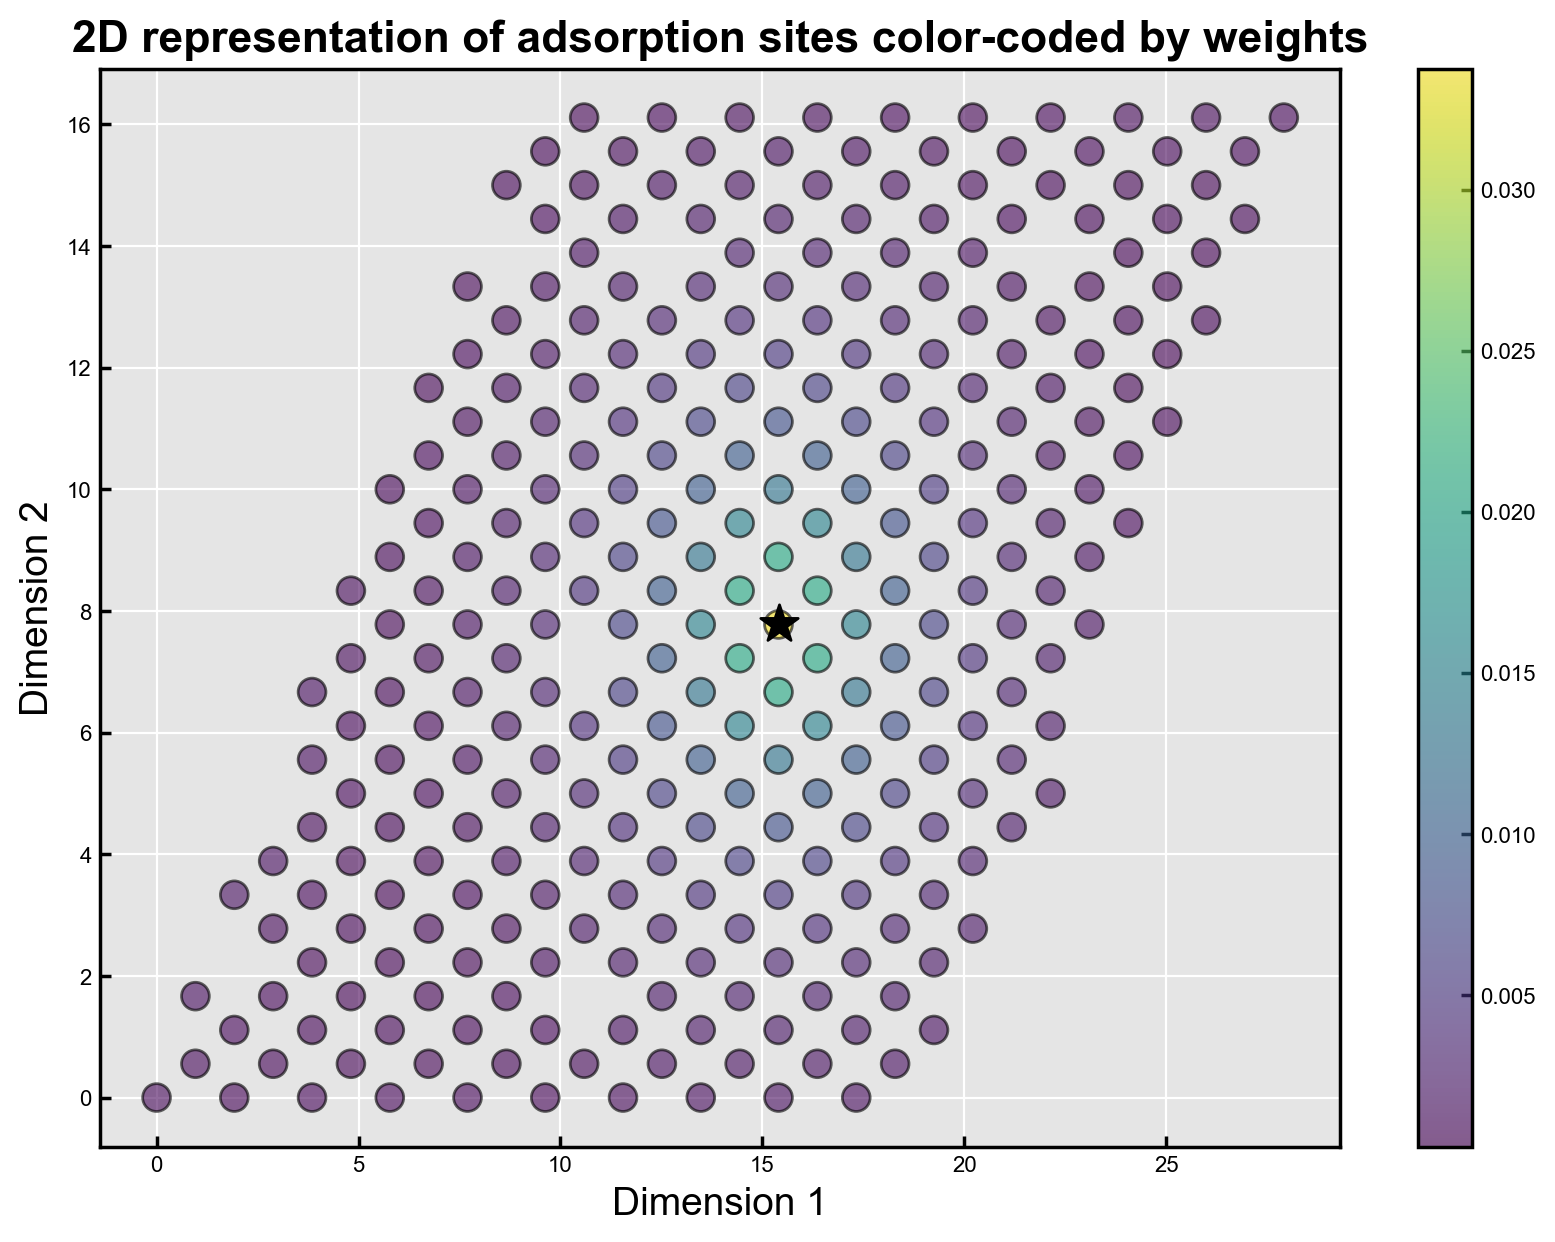

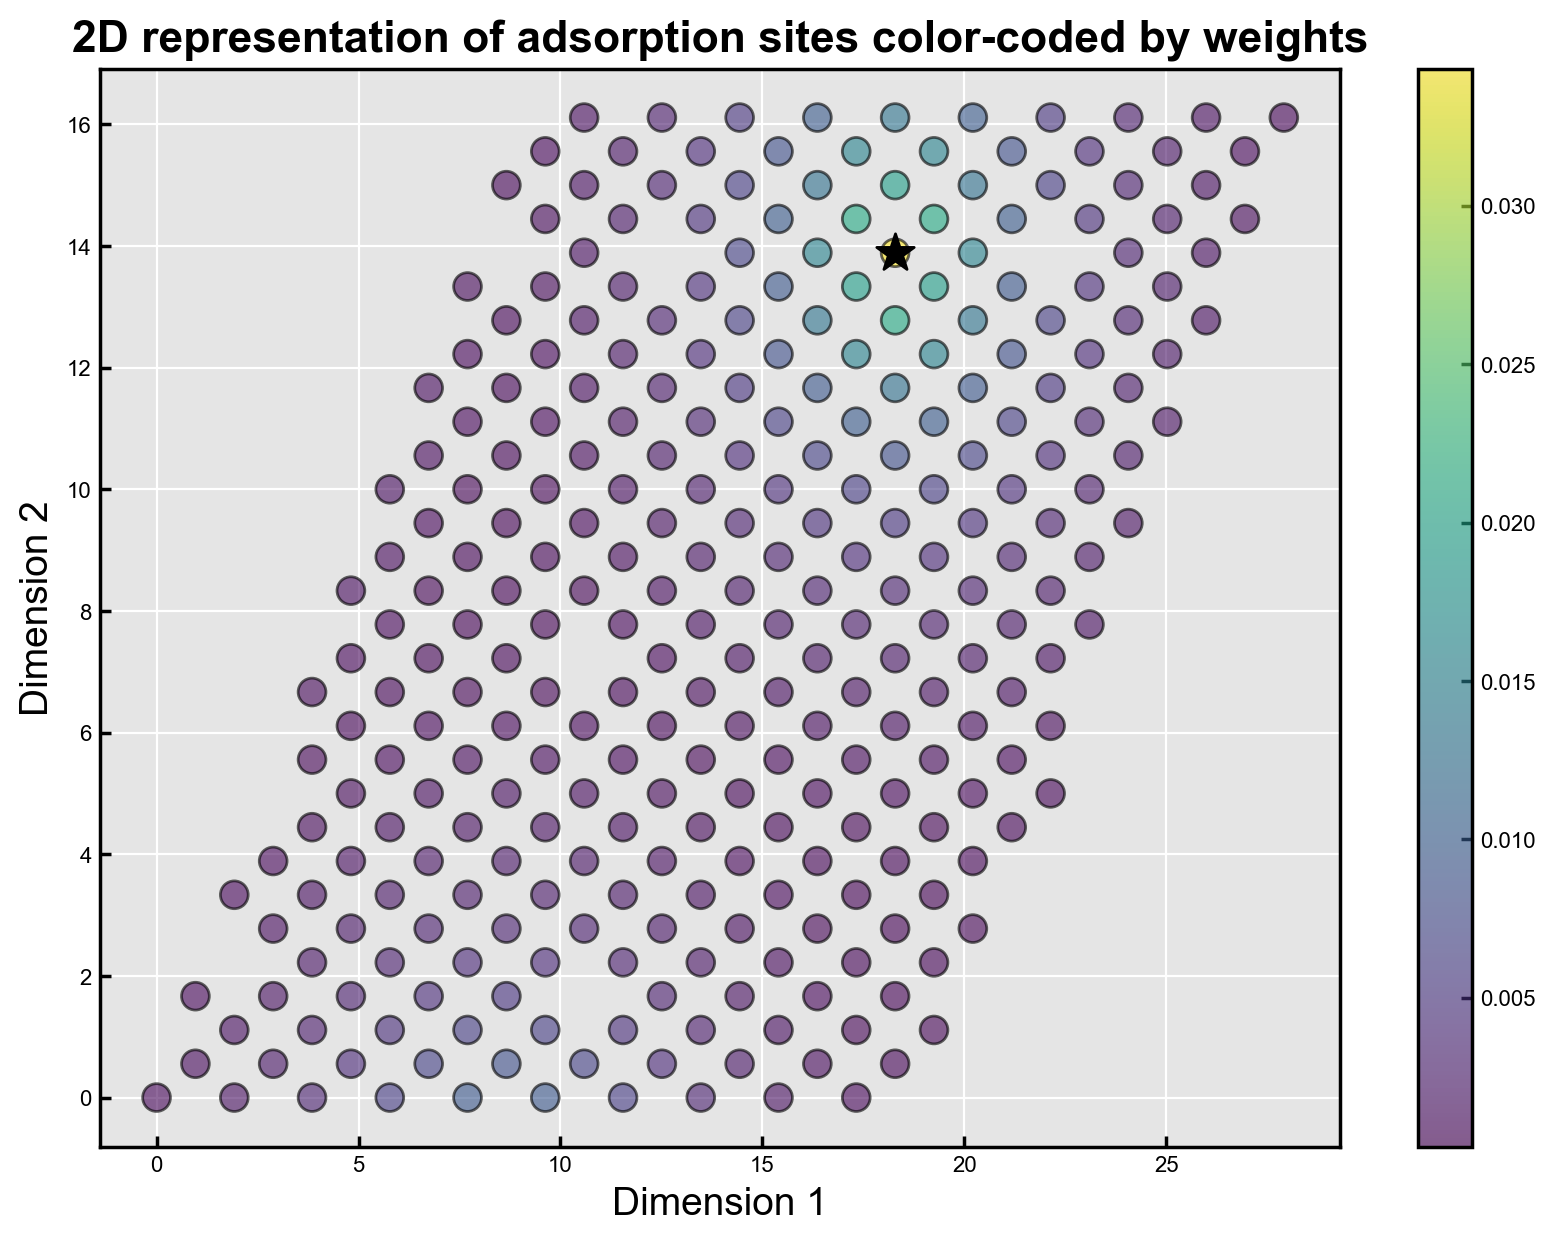

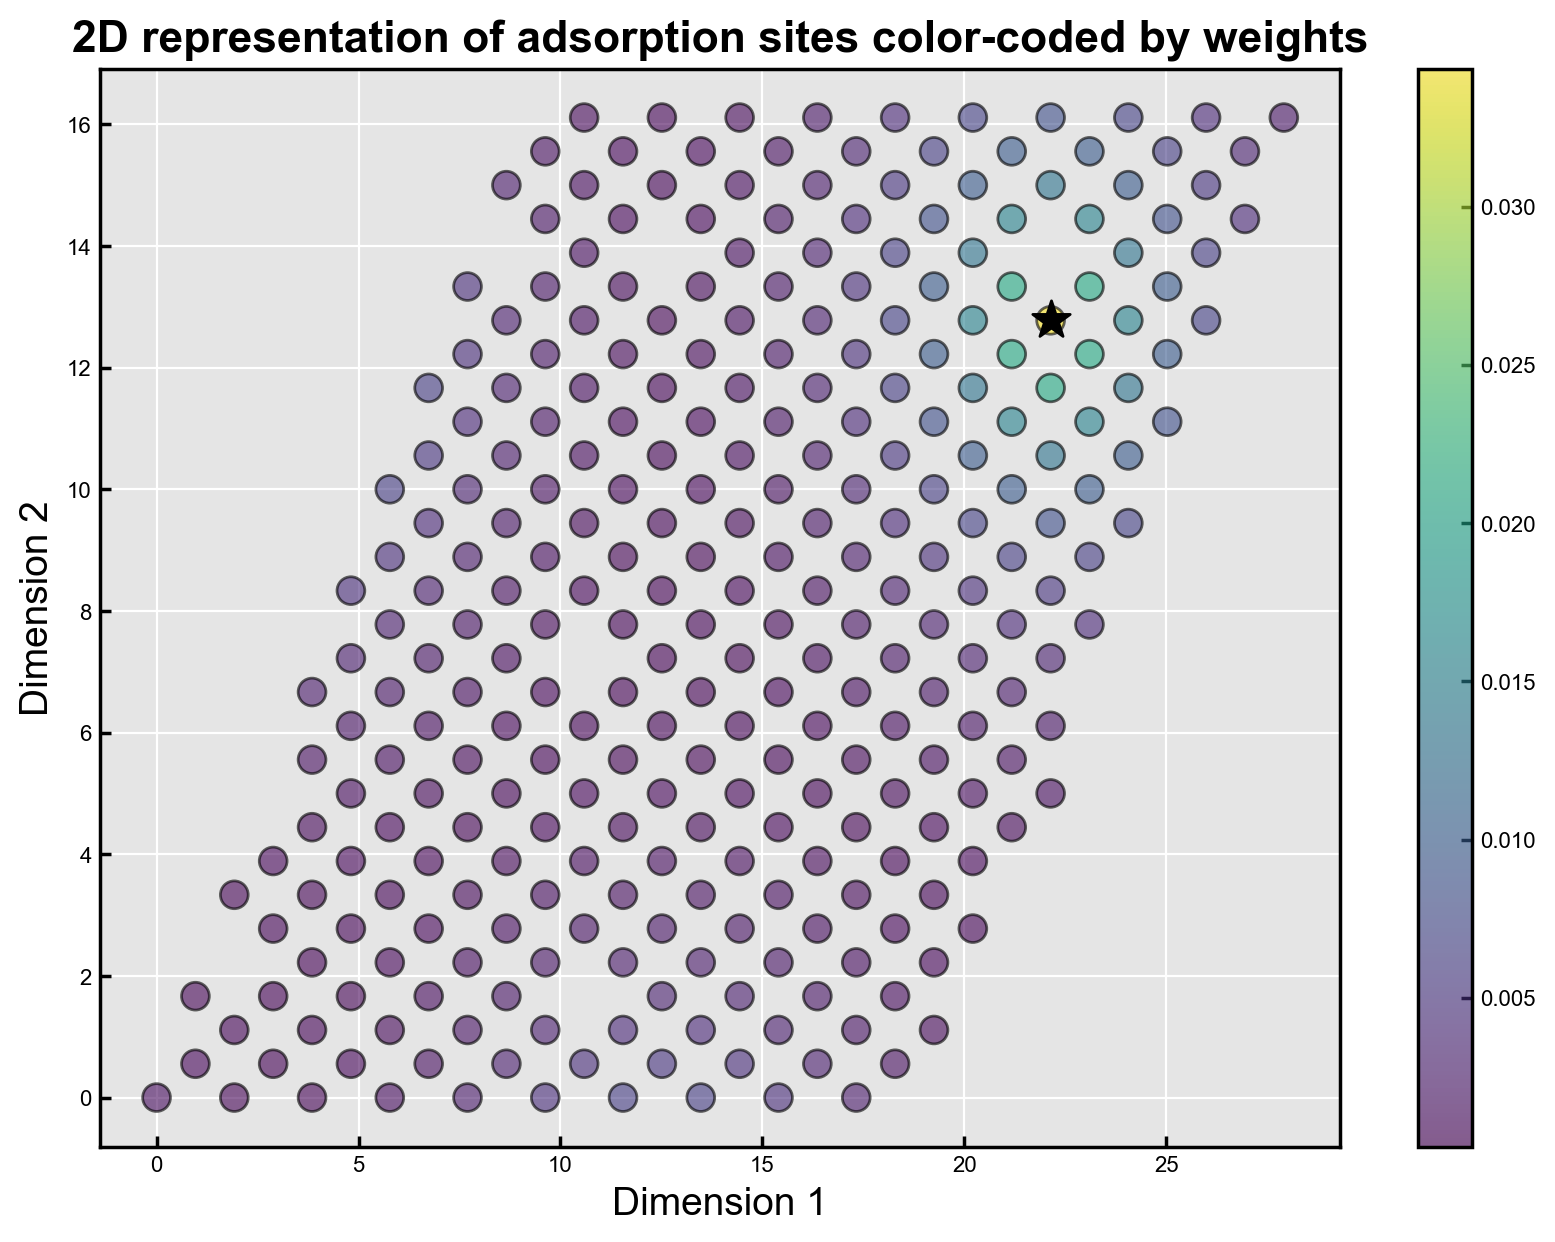

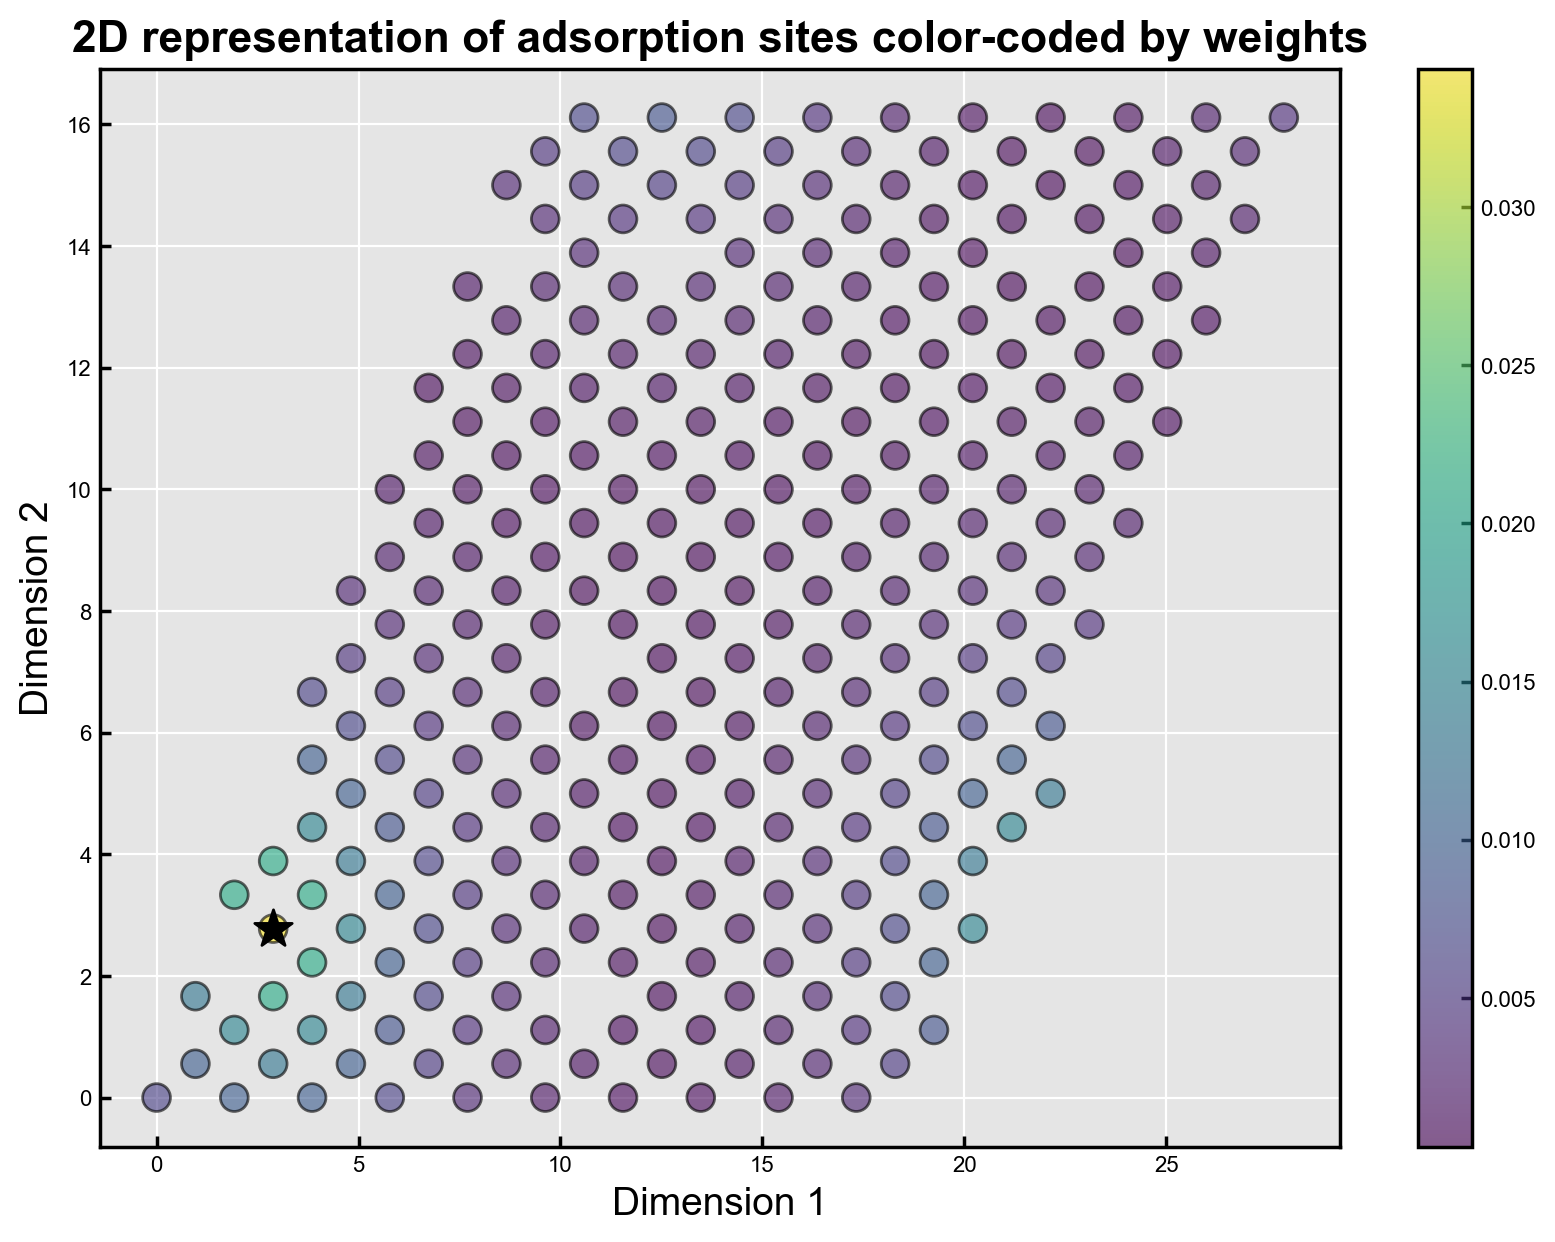

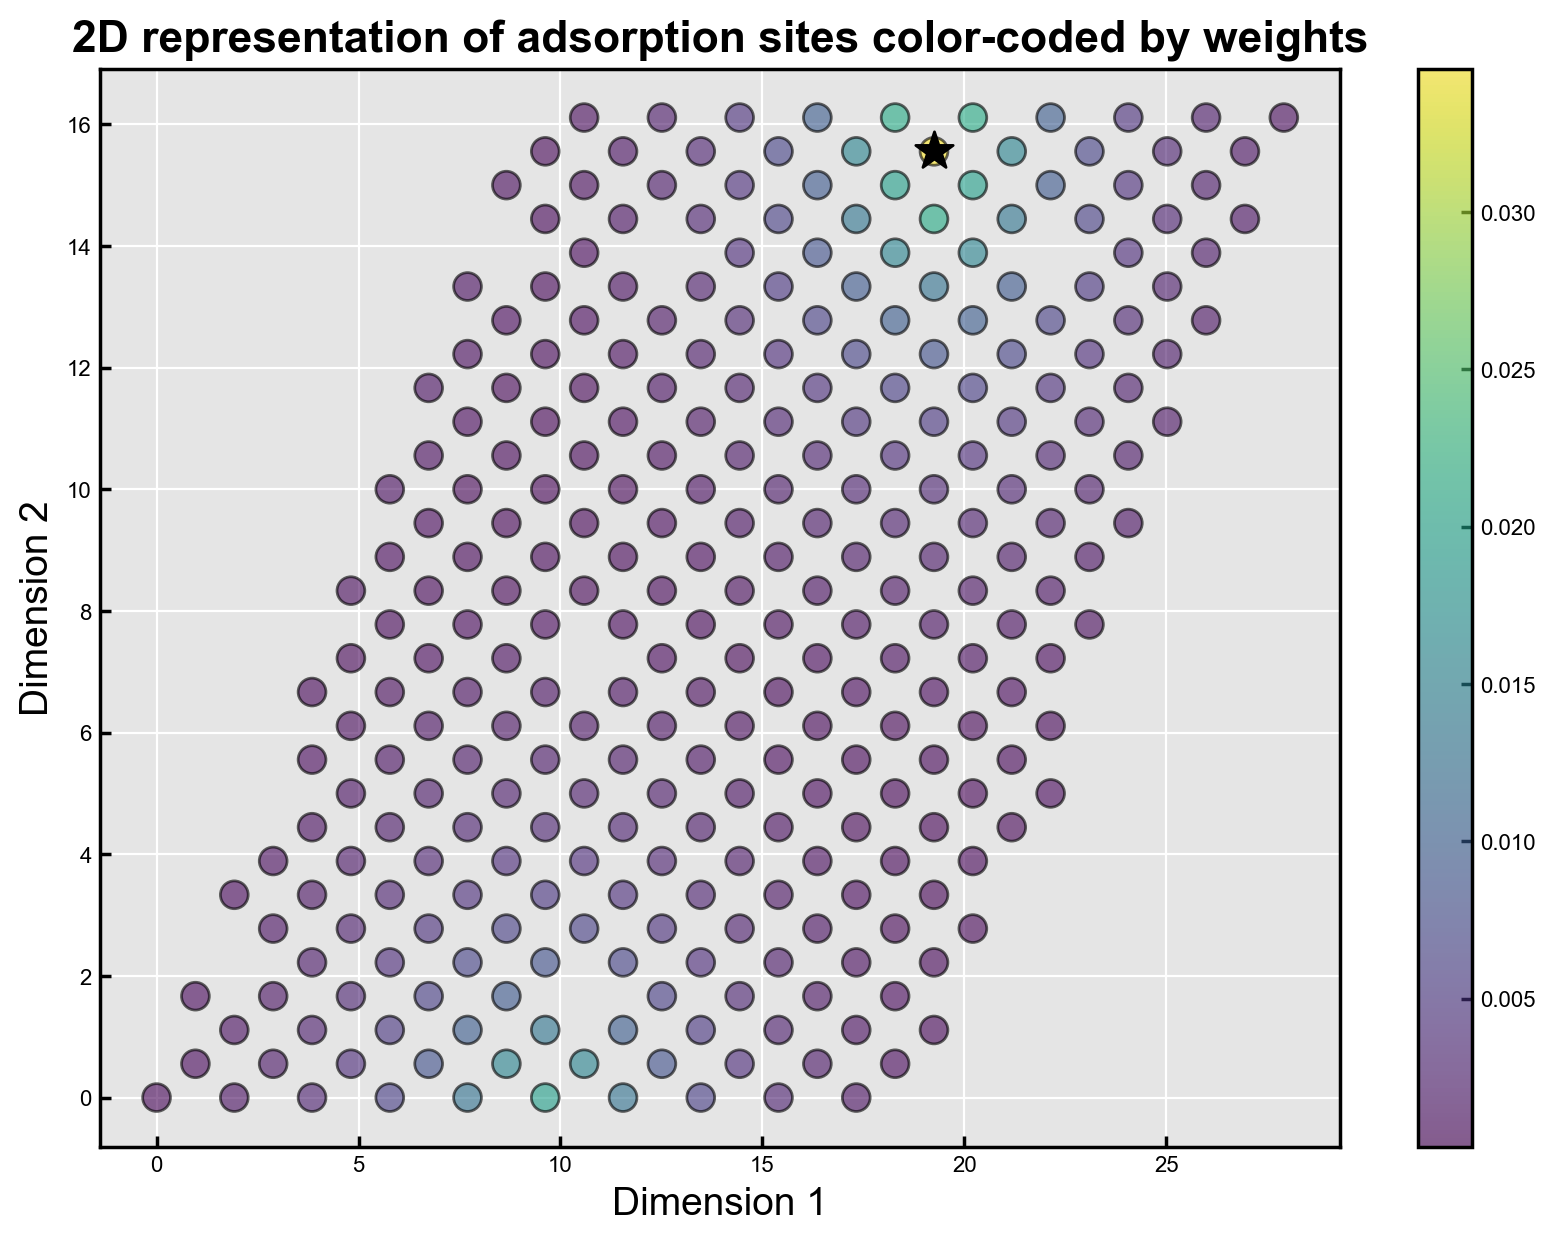

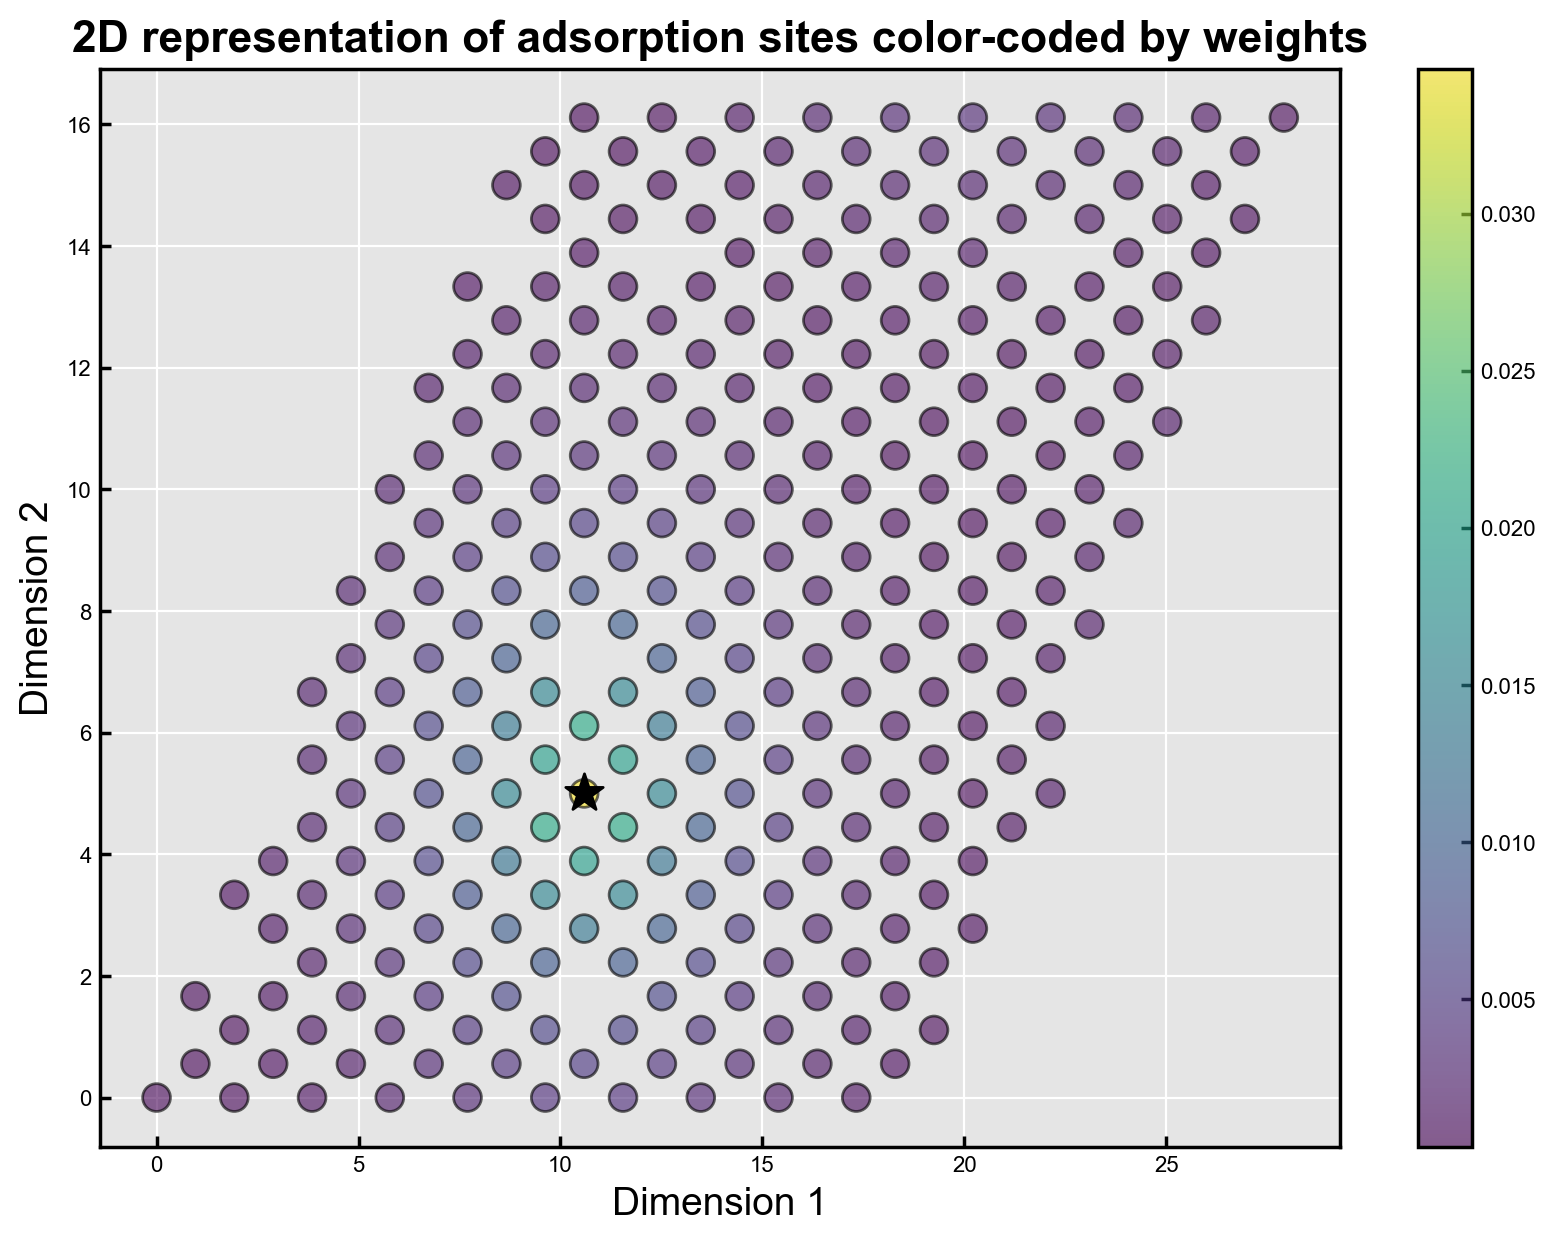

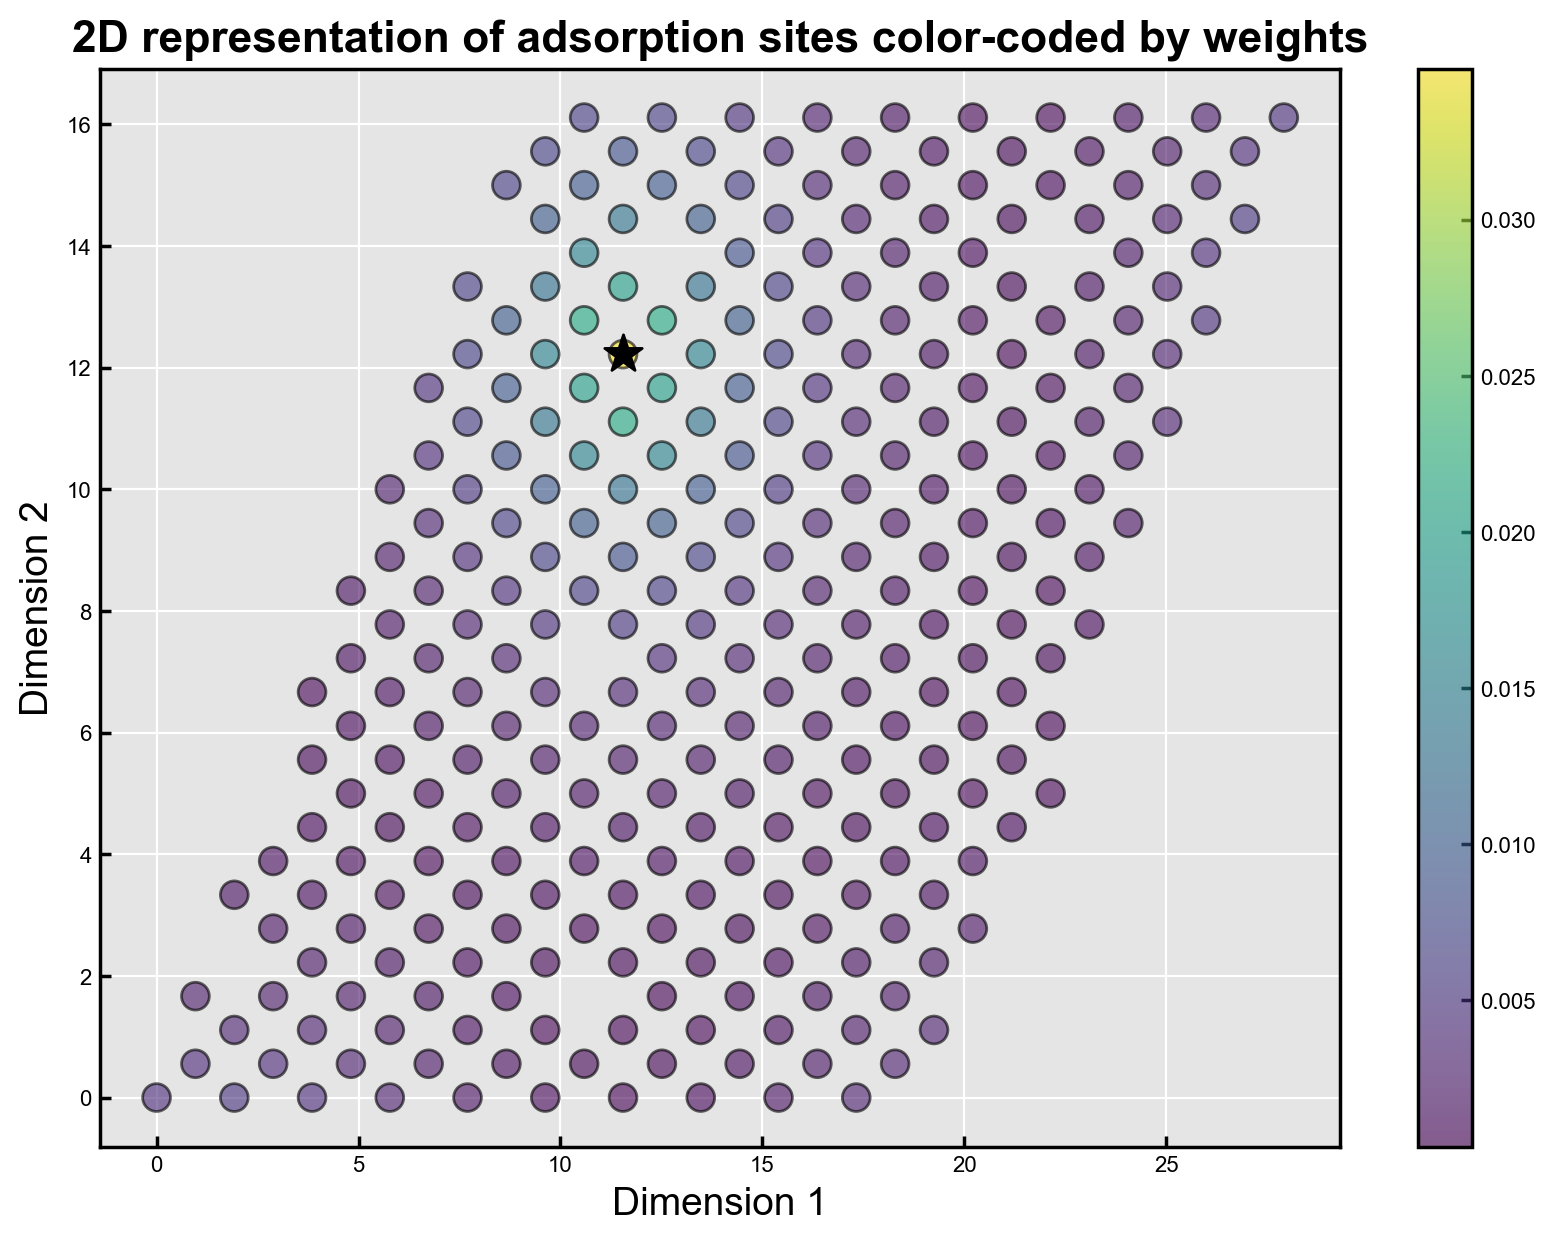

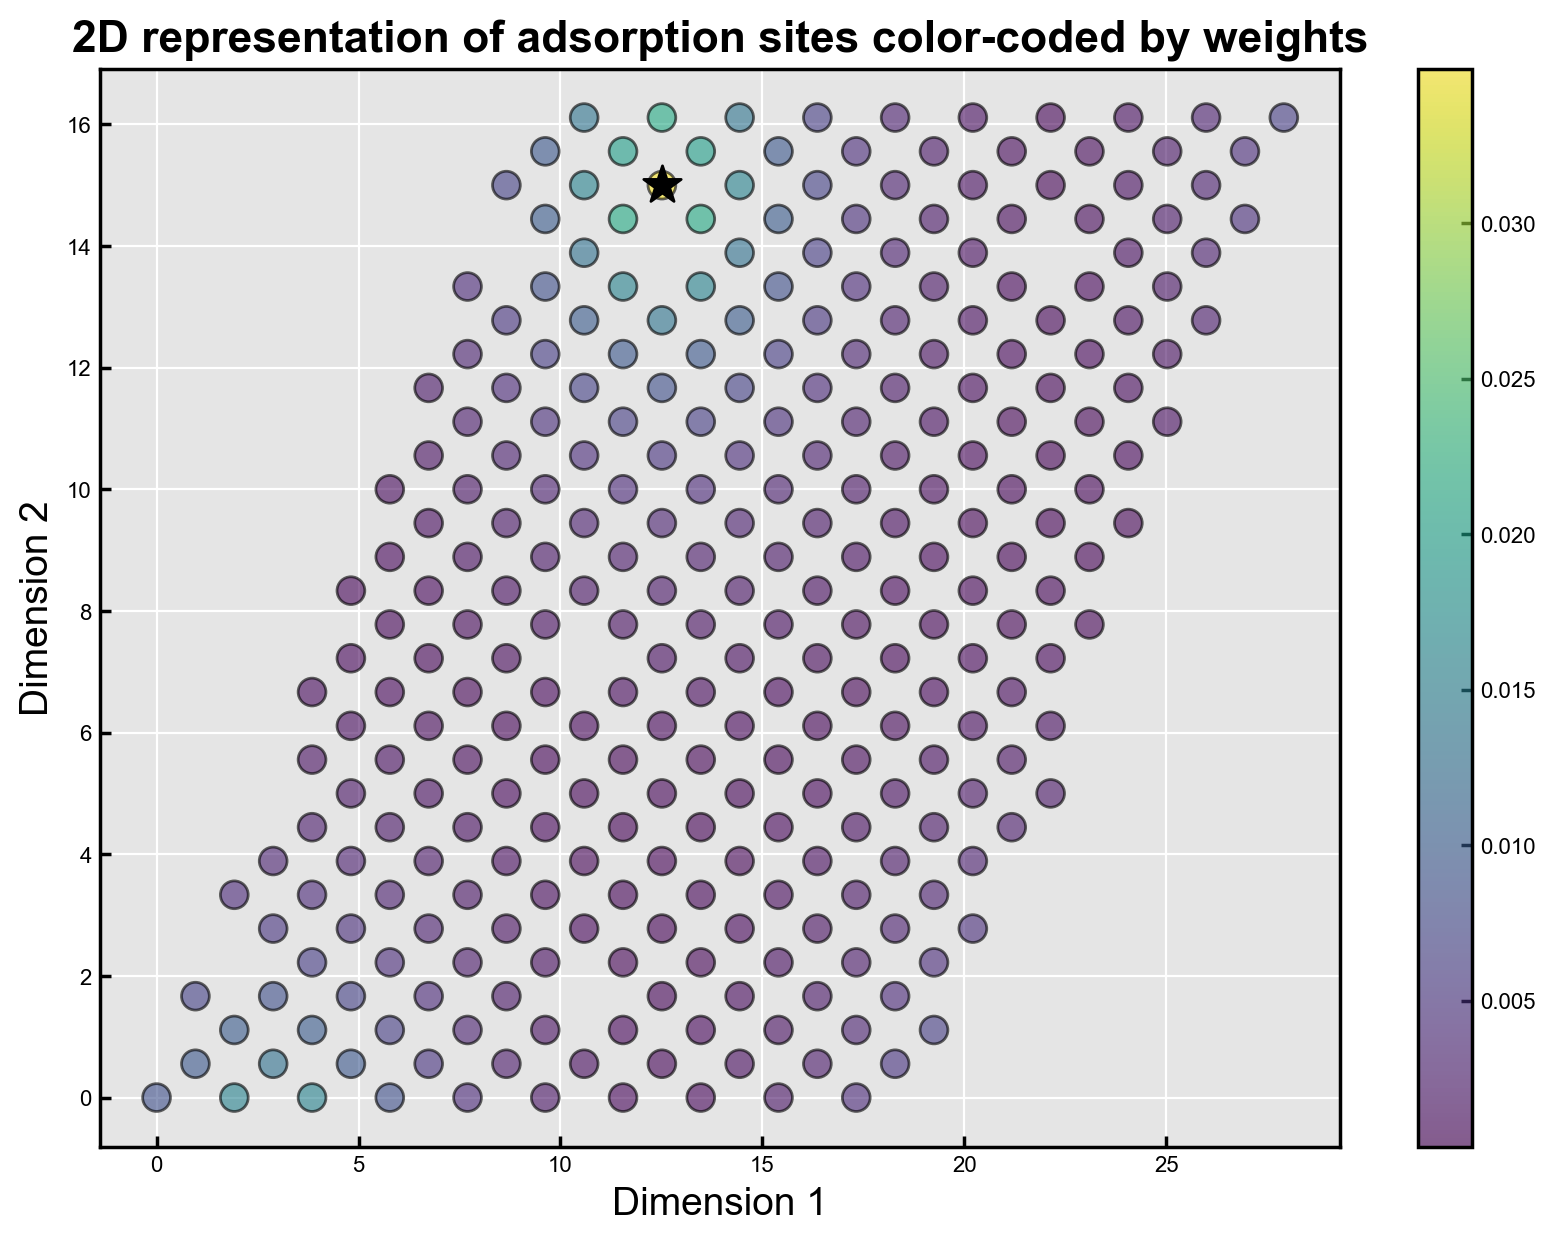

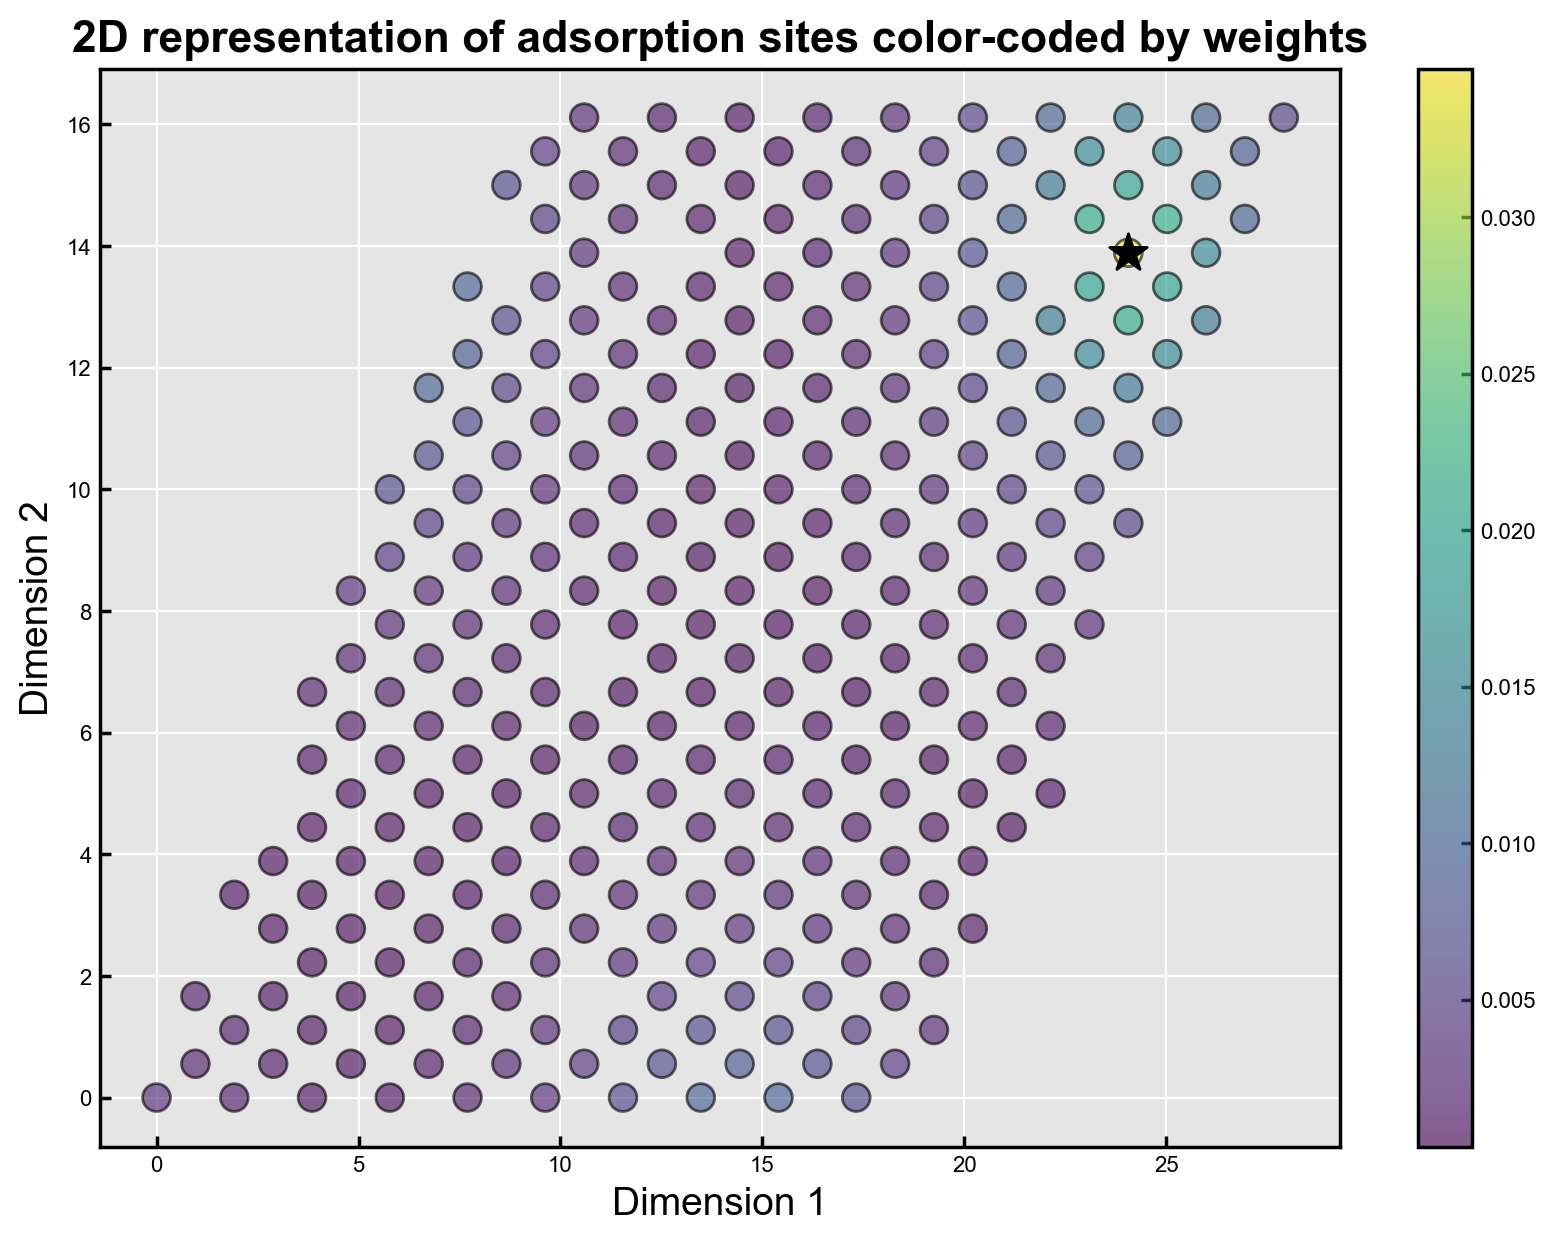

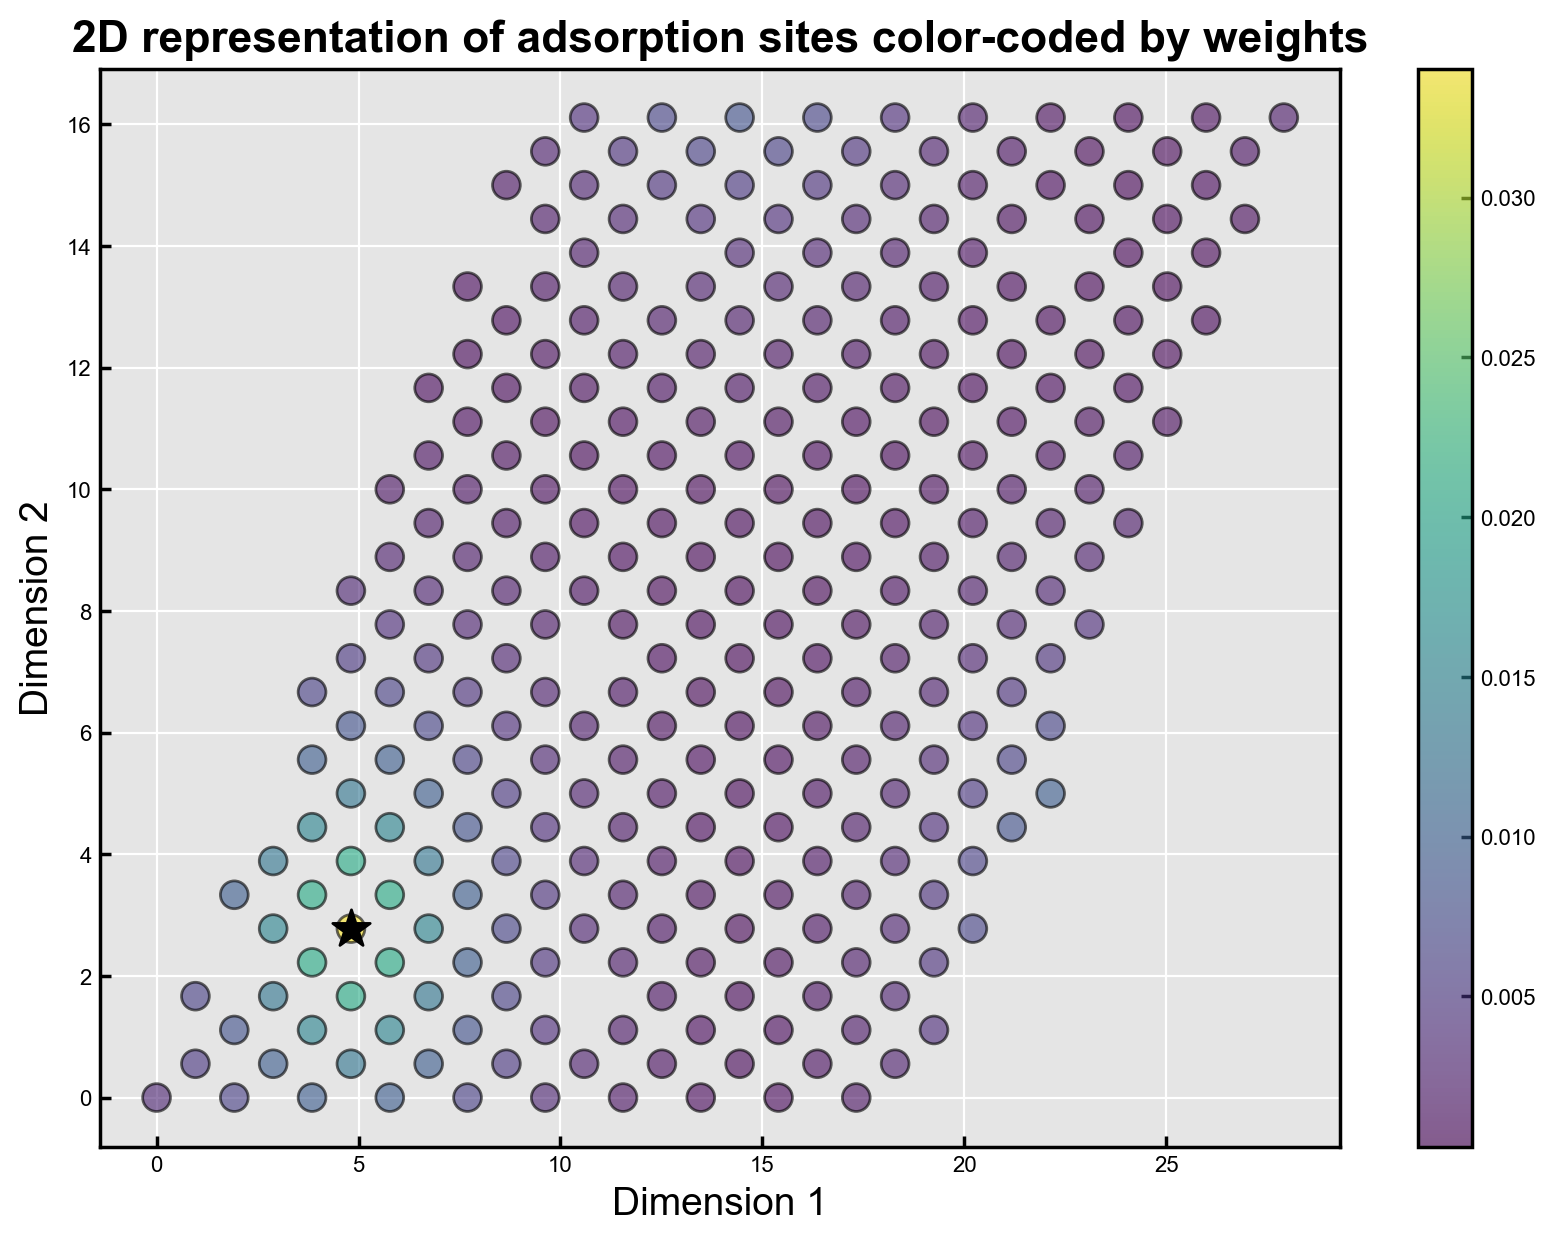

In [10]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.run(
    surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

Plot results

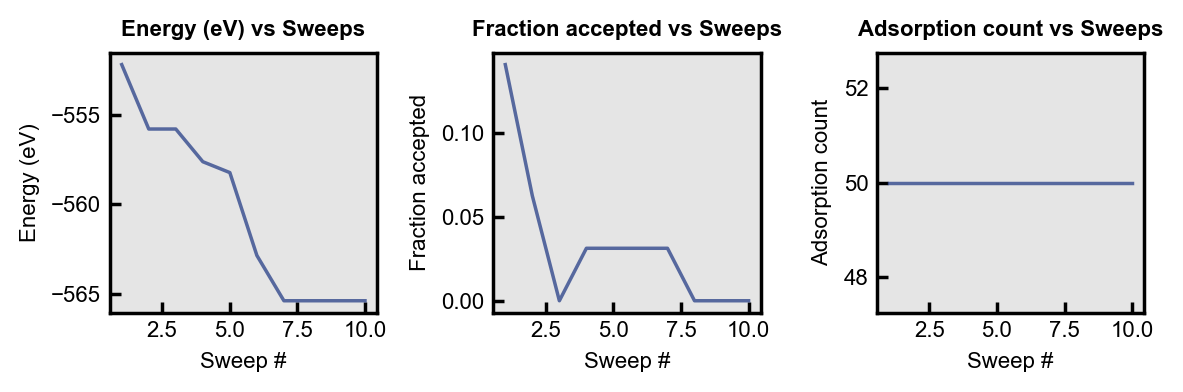

In [11]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)